# Projeto: Classificação e Detecção de Fissuras em Imagens
Este notebook contém a execução completa dos modelos utilizados no projeto:

- YOLOv8: Detecção de fissuras
- CNN (PyTorch): Classificação entre fissura térmica e de retração
- Random Forest com HOG: Classificação baseada em extração de características visuais

Cada modelo possui células de treino e teste separadas, com testes tanto para imagens únicas quanto para o conjunto completo de teste.

In [42]:
#!pip install ultralytics opencv-python torch torchvision scikit-learn scikit-image matplotlib tqdm joblib

## 1. CNN - Teste 

In [4]:
import torch
import json
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os

# === Recarregar modelo ===
class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(32, 64, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2)
        )
        self.fc = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(64 * 30 * 30, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 2)
        )

    def forward(self, x):
        return self.fc(self.conv(x))

# === Dispositivo e transformação ===
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# === Carregar mapeamento das classes ===
with open('../models/class_to_idx.json', 'r') as f:
    class_to_idx = json.load(f)

idx_to_class = {v: k for k, v in class_to_idx.items()}

# === Caminho da imagem ===
img_path = '../exemplot.png'
img = Image.open(img_path).convert('L')
img_tensor = transform(img).unsqueeze(0).to(DEVICE)

# === Salvar imagem processada (entrada real para a CNN) ===
# Reverter a normalização: x_norm = (x * std) + mean → std = 0.5, mean = 0.5
img_desnormalizada = img_tensor.squeeze().cpu() * 0.5 + 0.5  # shape: [H, W]
img_numpy = img_desnormalizada.numpy()

# Criar pasta se necessário
os.makedirs("outputs", exist_ok=True)

# Salvar usando matplotlib
plt.imsave("imagem_processada_pela_cnn.png", img_numpy, cmap='gray')

# === Carregar modelo e prever ===
model_cnn = CNN().to(DEVICE)
model_cnn.load_state_dict(torch.load('../models/cnn_model.pt', map_location=DEVICE))
model_cnn.eval()

with torch.no_grad():
    output = model_cnn(img_tensor)
    pred = torch.argmax(output, 1).item()

# === Exibir resultado seguro ===
classe = idx_to_class[pred]
classe_formatada = classe.split('_')[-1]  # remove prefixo se houver

print(f"CNN → A imagem '{img_path}' foi classificada como: {classe_formatada}")
print("🖼️ A imagem processada foi salva em: imagem_processada_pela_cnn.png")


CNN → A imagem '../exemplot.png' foi classificada como: thermal
🖼️ A imagem processada foi salva em: imagem_processada_pela_cnn.png


## 3. YOLOv8 - Teste (Individual)


0: 640x640 1 fissura, 134.7ms
Speed: 8.1ms preprocess, 134.7ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 640)
✅ Fissura detectada → Box: (0,32) → (585,525) | Confiança: 0.15

🖼️ Resultado salvo em: yolo_resultado_individual.png


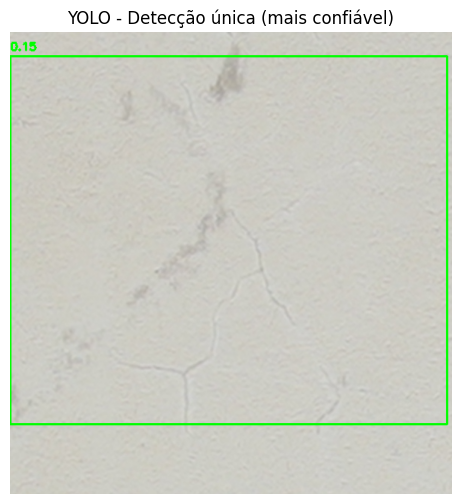

In [1]:
from ultralytics import YOLO
import cv2
import torch
import matplotlib.pyplot as plt

# === Caminhos ===
MODEL_PATH = '../yolo/runs/detect/fissura-detector/weights/best.pt'
IMG_PATH = '../exemplo.png'
OUTPUT_PATH = 'yolo_resultado_individual.png'
CONF_THRESHOLD = 0.1

# === Pré-processamento idêntico ao do treino ===
def preprocess_image(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized = clahe.apply(gray)
    blurred = cv2.GaussianBlur(equalized, (0, 0), 3)
    sharpened = cv2.addWeighted(equalized, 1.2, blurred, -0.2, 0)
    return cv2.cvtColor(sharpened, cv2.COLOR_GRAY2BGR)

# === Carregar imagem e modelo ===
model = YOLO(MODEL_PATH)
img = cv2.imread(IMG_PATH)
if img is None:
    raise FileNotFoundError(f"❌ Imagem não encontrada: {IMG_PATH}")

processed = preprocess_image(img.copy())

# === Inferência ===
results = model(processed, conf=CONF_THRESHOLD)[0]
boxes = results.boxes

# === Considerar apenas a fissura mais confiável ===
if boxes is not None and len(boxes) > 0:
    confs = boxes.conf
    idx_max = torch.argmax(confs).item()
    x1, y1, x2, y2 = map(int, boxes.xyxy[idx_max])
    conf = float(confs[idx_max])

    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(img, f"{conf:.2f}", (x1, y1 - 8),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    print(f"✅ Fissura detectada → Box: ({x1},{y1}) → ({x2},{y2}) | Confiança: {conf:.2f}")
else:
    print("❌ Nenhuma fissura detectada.")

# === Salvar e exibir ===
cv2.imwrite(OUTPUT_PATH, img)
print(f"\n🖼️ Resultado salvo em: {OUTPUT_PATH}")

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6, 6))
plt.imshow(img_rgb)
plt.title("YOLO - Detecção única (mais confiável)")
plt.axis("off")
plt.show()


## OBS: RESULTADO DO TESTE DO YOLOv8 COM CONJUNTO DE TESTE

In [9]:
import os
import torch
from ultralytics import YOLO
import cv2

# === Caminhos ===
MODEL_PATH = '../yolo/runs/detect/fissura-detector/weights/best.pt'
DATASET_YAML = '../yolo/fissure.yaml'
TEST_DIR = '../yolo/images/test/processadas'
OUTPUT_DIR = 'yolo_test_outputs_detalhado'
CONF_THRESHOLD = 0.1

os.makedirs(OUTPUT_DIR, exist_ok=True)

# === Carrega modelo treinado ===
model = YOLO(MODEL_PATH)

# === Avaliação formal com métricas
print("📊 Avaliação com métricas no conjunto de teste:")
metrics = model.val(data=DATASET_YAML, split='test', imgsz=640)

print(f"\n→ mAP@0.5:         {metrics.box.map50:.3f}")
print(f"→ mAP@0.5:0.95:    {metrics.box.map:.3f}")
print(f"→ Precisão média:  {metrics.box.mp:.3f}")
print(f"→ Revocação média: {metrics.box.mr:.3f}")

# === Avaliação imagem por imagem com confidências
print("\n🖼️ Resultado por imagem:")

for fname in sorted(os.listdir(TEST_DIR)):
    if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue

    img_path = os.path.join(TEST_DIR, fname)
    img = cv2.imread(img_path)
    results = model(img, conf=CONF_THRESHOLD)[0]

    if results.boxes is not None and len(results.boxes) > 0:
        confs = results.boxes.conf.cpu().numpy()
        print(f"{fname}: {len(confs)} fissura(s) detectada(s)")
        for i, conf in enumerate(confs):
            print(f"   → Fissura {i+1}: confiança {conf:.2%}")

        # Desenhar boxes e salvar imagem anotada
        for box, conf in zip(results.boxes.xyxy, confs):
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img, f"{conf:.2%}", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        save_path = os.path.join(OUTPUT_DIR, f"out_{fname}")
        cv2.imwrite(save_path, img)

    else:
        print(f"{fname}: ❌ Nenhuma fissura detectada.")


📊 Avaliação com métricas no conjunto de teste:
Ultralytics 8.3.127  Python-3.13.3 torch-2.7.0+cpu CPU (13th Gen Intel Core(TM) i5-1335U)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 151.547.1 MB/s, size: 64.9 KB)


val: Scanning C:\Users\Inteli\Downloads\fissure_project_full_integrated (1)\yolo\labels\test\processadas... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<00:00, 1026.31it/s]

val: New cache created: C:\Users\Inteli\Downloads\fissure_project_full_integrated (1)\yolo\labels\test\processadas.cache



c:\Users\Inteli\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


                   all         20         20      0.724      0.789      0.709        0.4
Speed: 2.5ms preprocess, 95.7ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\val

→ mAP@0.5:         0.709
→ mAP@0.5:0.95:    0.400
→ Precisão média:  0.724
→ Revocação média: 0.789

🖼️ Resultado por imagem:

0: 640x640 1 fissura, 191.1ms
Speed: 5.3ms preprocess, 191.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
FR100.PNG: 1 fissura(s) detectada(s)
   → Fissura 1: confiança 14.70%

0: 608x640 1 fissura, 171.1ms
Speed: 3.8ms preprocess, 171.1ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)
FR91.PNG: 1 fissura(s) detectada(s)
   → Fissura 1: confiança 22.64%

0: 640x640 1 fissura, 245.1ms
Speed: 4.4ms preprocess, 245.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)
FR92.PNG: 1 fissura(s) detectada(s)
   → Fissura 1: confiança 27.03%

0: 640x640 2 fissuras, 224.2ms
Speed: 6.4ms preprocess, 224.2ms inferenc